### Решаемая задача:

Необходимо уменьшить потребление электроэнергии на этапе обработки стали в условиях металлургического комбината. Требуется построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Несколько датасетов включают в себя данные по производственному процессу - легирование стали. Это процесс состоит из циклов: измерение температуры - нагрев и добавлением легирующих элементов - перемешивание - измерение температуры и химический анализ. Если химический анализ не показывает требуемые параметры стали, то циклов начинается снова. Один из датасетов включает в себя данные по измеренной температуре на разных этапах по партиям.

#### Целевой признак: последняя измеренная температура для партии ("key" - номер партии)

#### Метрика: MAE

# 1.Исследуем и подготавливаем данные

In [152]:
import pandas as pd
import numpy as np
import time
from datetime import date

In [153]:
# данные об электродах
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
print(data_arc.head())
data_arc.info()

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


По количеству повторений значений key можно судить о количестве циклов нагрева для каждой партии.

In [154]:
# данные о подаче сыпучих материалов (объём)
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
print(data_bulk.head())
data_bulk.info()

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-nu

In [155]:
# данные о подаче сыпучих материалов (время)
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
print(data_bulk_time.head())
data_bulk_time.info()

   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  


In [156]:
# данные о продувке сплава газом
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
print(data_gas.head())
data_gas.info()

   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [157]:
# результаты измерения температуры
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
print(data_temp.head())
data_temp.info()

   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [158]:
data_temp.isnull().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

In [159]:
data_temp=data_temp.dropna()

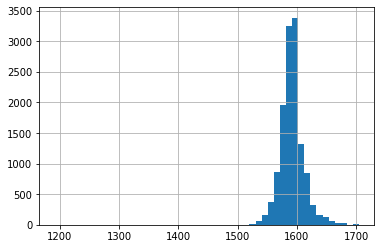

In [160]:
data_temp['Температура'].hist(bins=50)

In [161]:
data_temp['Температура'].shape

(13006,)

In [162]:
data_temp = data_temp.query('Температура >= 1450')

In [163]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
key             12999 non-null int64
Время замера    12999 non-null object
Температура     12999 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.2+ KB


Исключено 7 выбросов, которые сильно не вписывались в картину нормального распределения

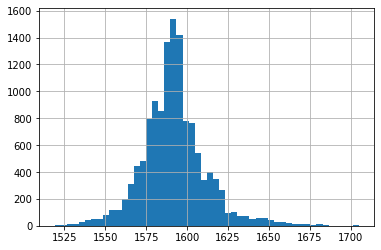

In [164]:
data_temp['Температура'].hist(bins=50)

In [165]:
data_temp['key'].value_counts()

44      16
46      16
1513    16
1689    15
2108    15
        ..
2870     1
2878     1
2886     1
2983     1
2543     1
Name: key, Length: 3215, dtype: int64

Температуру для некоторых партий мерили по 16 раз.

In [166]:
# данные о проволочных материалах (объём)
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
print(data_wire.head())
data_wire.info()

   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 

In [167]:
# данные о проволочных материалах (время)
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
print(data_wire_time.head(10))
data_wire_time.info()

   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:59:02  2019-05-03 13:59:54    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:28:46                  NaN    NaN    NaN    NaN    NaN   
7    8  2019-05-03 15:03:42                  NaN    NaN    NaN    NaN    NaN   
8    9  2019-05-03 15:42:43  2019-05-03 15:58:12    NaN    NaN    NaN    NaN   
9   10  2019-05-03 16:20:25  2019-05-03 16:21:02    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    

In [168]:
print(data_arc['key'].value_counts().shape)

(3214,)


In [169]:
print(data_gas['key'].value_counts().shape)

(3239,)


In [170]:
print(data_temp['key'].value_counts().shape)

(3215,)


In [171]:
print(data_wire['key'].value_counts().shape)

(3081,)


In [172]:
print(data_wire_time['key'].value_counts().shape)

(3081,)


In [173]:
print(data_bulk['key'].value_counts().shape)

(3129,)


In [174]:
print(data_bulk_time['key'].value_counts().shape)

(3129,)


Не по всем партиям есть все данные. В процессе сборки общей таблицы останутся данные о 2329 партиях из-за того, что по некоторым партиям в данных имеется только один замер температуры. 

# 2.Подготовка данных для общей таблицы для МО

#### - Преобразования со столбцами с временем, расчёт времени нагрева дуги "time_nagrev_sec" 

In [175]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], 
                                                  format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], 
                                                 format='%Y-%m-%dT%H:%M:%S')
data_arc['time_nagrev'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['time_nagrev_sec'] = data_arc['time_nagrev'].dt.total_seconds()
print(data_arc.head())
data_arc.info()

   key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.692755   

   Реактивная мощность time_nagrev  time_nagrev_sec  
0             0.687084    00:03:48            228.0  
1             0.520285    00:03:05            185.0  
2             0.498805    00:02:52            172.0  
3             1.062669    00:06:05            365.0  
4             0.414397    00:02:28            148.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime6

#### - Расчёт полной мощности, которая характеризует затраты на электроэнергию

In [176]:
data_arc['Power'] = (((data_arc['Активная мощность'])*2) + ((data_arc['Реактивная мощность'])*2))**1/2

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time_nagrev,time_nagrev_sec,Power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,228.0,1.663142
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,185.0,1.325892
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,172.0,1.243169
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,365.0,2.722032
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,148.0,1.107152


### Создание датасета с основными признаками, характеризующие затраты энергии

In [177]:
data_arc_pivot=data_arc[['key', 'time_nagrev_sec', 'Power']]
data_arc_pivot = data_arc_pivot.set_index('key')
data_arc_pivot.head()

,time_nagrev_sec,Power
key,,
1,228.0,1.663142
1,185.0,1.325892
1,172.0,1.243169
1,365.0,2.722032
1,148.0,1.107152


### 2.1 Подготовка признаков из других таблиц

#### - Температура

##### Партии с замером температуры меньше двух раз исключаем, т.к. нам надо 2 замера температуры: первый и последний.

In [178]:
data_temp.groupby('key').count().tail()

,Время замера,Температура
key,,
3237,1,1
3238,1,1
3239,1,1
3240,1,1
3241,1,1


In [179]:
df_temp = data_temp.groupby('key').count()
df_temp['quantity'] = df_temp['Время замера']
df_temp = df_temp.query('quantity > 1')
df1_temp = df_temp[['quantity']]

print(df1_temp.head())
df1_temp.info()

     quantity
key          
1           5
2           6
3           5
4           3
5           2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 1 columns):
quantity    2475 non-null int64
dtypes: int64(1)
memory usage: 38.7 KB


In [180]:
df1_temp = df1_temp.reset_index(drop=False)
data_temp=data_temp.merge(df1_temp, on='key')
data_temp.head()

,key,Время замера,Температура,quantity
0,1,2019-05-03 11:16:18,1571.0,5
1,1,2019-05-03 11:25:53,1604.0,5
2,1,2019-05-03 11:29:11,1618.0,5
3,1,2019-05-03 11:30:01,1601.0,5
4,1,2019-05-03 11:30:39,1613.0,5


In [181]:
data_temp_pivot = data_temp.pivot_table(index = ["key"], values = "Время замера", 
                                        aggfunc = "first")
#data_temp_pivot.head()

In [182]:
data_temp1=data_temp_pivot.merge(data_temp, on='Время замера')
data_temp1=data_temp1.set_index('key')
#data_temp1.head()

In [183]:
data_temp_pivot2 = data_temp.pivot_table(index = ["key"], values = "Время замера", 
                                        aggfunc = "last")
data_temp2=data_temp_pivot2.merge(data_temp, on='Время замера')
data_temp2=data_temp2.set_index('key')
#data_temp2.head()

In [184]:
data_temp1['First_zamer'] = data_temp1['Температура']
data_temp1 = data_temp1.drop(['Температура','Время замера','quantity'] , axis=1)
#data_temp1.head()

In [185]:
data_temp2['Last_zamer'] = data_temp2['Температура']
data_temp2 = data_temp2.drop(['Температура','Время замера','quantity'] , axis=1)
#data_temp2.head()

In [186]:
data_temp1=data_temp1.merge(data_temp2, on='key')
#data_temp1.head()

In [187]:
data_for_deal=data_temp1.merge(data_arc_pivot, on='key')
data_for_deal.head()

,First_zamer,Last_zamer,time_nagrev_sec,Power
key,,,,
1,1571.0,1613.0,228.0,1.663142
1,1571.0,1613.0,185.0,1.325892
1,1571.0,1613.0,172.0,1.243169
1,1571.0,1613.0,365.0,2.722032
1,1571.0,1613.0,148.0,1.107152


In [188]:
data_for_deal = data_for_deal.pivot_table(index = ['key', 'First_zamer', 'Last_zamer'], 
                                         values = ['time_nagrev_sec', 'Power'], 
                                        aggfunc = 'sum')
data_for_deal = data_for_deal.reset_index(drop=False)
data_for_deal = data_for_deal.set_index('key')
data_for_deal.head()

,First_zamer,Last_zamer,Power,time_nagrev_sec
key,,,,
1,1571.0,1613.0,8.061388,1098.0
2,1581.0,1602.0,5.050710,811.0
3,1596.0,1599.0,4.124958,655.0
4,1601.0,1625.0,5.269548,741.0
5,1576.0,1602.0,5.599815,869.0


#### - Газ

In [189]:
data_for_deal=data_for_deal.merge(data_gas, on='key')
#data_for_deal.head()

#### - Проволока

In [190]:
df_wire=data_wire.fillna(0)
df_wire_New = df_wire.set_index('key')
print(df_wire_New.head())
df_wire_New.info()

        Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
key                                                                       
1    60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5    89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     Wire 9  
key          
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081

In [191]:
data_for_deal=data_for_deal.merge(df_wire_New, on='key')

#### - Сыпучие материалы

In [192]:
df_bulk=data_bulk.fillna(0)
df_bulk = df_bulk.set_index('key')
print(df_bulk.head())
df_bulk.info()

     Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
key                                                                           
1       0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
2       0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
3       0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
4       0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
5       0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   

     Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
key                                                        
1        0.0      0.0    206.0      0.0    150.0    154.0  
2        0.0      0.0    206.0      0.0    149.0    154.0  
3        0.0      0.0    205.0      0.0    152.0    153.0  
4        0.0      0.0    207.0      0.0    153.0    154.0  
5        0.0      0.0    203.0      0.0    151.0    152.0  
<class 'pandas.core.frame.

In [193]:
data_for_deal=data_for_deal.merge(df_bulk, on='key')

In [194]:
data_for_deal = data_for_deal.set_index('key')
print(data_for_deal.shape)
data_for_deal.head(5)

(2329, 29)


,First_zamer,Last_zamer,Power,time_nagrev_sec,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,8.061388,1098.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,1581.0,1602.0,5.050710,811.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,1596.0,1599.0,4.124958,655.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,1601.0,1625.0,5.269548,741.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,1576.0,1602.0,5.599815,869.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


По данным о газе было 3239 партии. Но не было адекватных замеров температуры, либо их не было вообще. Таким образом, остались данных только по 2329 партиям.

### 3.Разделение выборок на обучающую и тестовую

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df_train, df_valid = train_test_split(data_for_deal, test_size=0.25, random_state=12345)

features_train = df_train.drop(['Last_zamer'], axis=1)
target_train = df_train['Last_zamer']

features_valid = df_valid.drop(['Last_zamer'], axis=1)
target_valid = df_valid['Last_zamer']

### 4. Обучение модели, предсказание, расчёт метрики MAE

#### DecisionTreeRegressor

In [196]:
from sklearn.tree import DecisionTreeRegressor

for m in range(20, 30, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth=m)

    model.fit(features_train, target_train)
    train_predictions = model.predict(features_train)
    valid_predictions = model.predict(features_valid)
    mae_train = mean_absolute_error(target_train, train_predictions)
    mae_valid= mean_absolute_error(target_valid, valid_predictions)
    print("max_depth:", m)
    print("MAE_train:", mae_train)
    print("MAE_test:", mae_valid)

max_depth: 20
MAE_train: 0.19486675981521365
MAE_test: 8.88854855835988
max_depth: 23
MAE_train: 0.04191456373586983
MAE_test: 8.779650709496336
max_depth: 26
MAE_train: 0.0
MAE_test: 8.915951972555746
max_depth: 29
MAE_train: 0.0
MAE_test: 8.915951972555746


In [197]:
model = DecisionTreeRegressor(random_state=12345, max_depth=20)

model.fit(features_train, target_train)
train_predictions = model.predict(features_train)
valid_predictions = model.predict(features_valid)
mae_train = mean_absolute_error(target_train, train_predictions)
mae_valid= mean_absolute_error(target_valid, valid_predictions)

print("MAE_train:", mae_train)
print("MAE_test:", mae_valid)

MAE_train: 0.19486675981521365
MAE_test: 8.88854855835988


#### CatBoostRegressor

In [198]:
from catboost import CatBoostRegressor

for n in range(2,6,1):
    modelCatBoost = CatBoostRegressor(loss_function="MAE", iterations=300,  learning_rate = 0.08,
                                      max_depth=n, verbose = False)
    
    modelCatBoost = modelCatBoost.fit(features_train, target_train)
    
    train_predictions = modelCatBoost.predict(features_train)
    valid_predictions = modelCatBoost.predict(features_valid)
    mae_train = mean_absolute_error(target_train, train_predictions)
    mae_valid = mean_absolute_error(target_valid, valid_predictions)
    print("max_depth:", n)
    print("MAE_train:", mae_train)
    print("MAE_test:", mae_valid)

max_depth: 2
MAE_train: 5.331635599699535
MAE_test: 6.294744665618465
max_depth: 3
MAE_train: 4.940474019012294
MAE_test: 6.166300091675394
max_depth: 4
MAE_train: 4.569601861867028
MAE_test: 6.1001035082100845
max_depth: 5
MAE_train: 4.178828359709897
MAE_test: 6.1692584367732906


In [199]:
%%time

modelCatBoost = CatBoostRegressor(loss_function="MAE", iterations=300, learning_rate = 0.08,
                                  max_depth=4, verbose = False)
modelCatBoost = modelCatBoost.fit(features_train, target_train)
    
train_predictions = modelCatBoost.predict(features_train)
valid_predictions = modelCatBoost.predict(features_valid)
mae_train = mean_absolute_error(target_train, train_predictions)
mae_valid = mean_absolute_error(target_valid, valid_predictions)
print("MAE_train:", mae_train)
print("MAE_test:", mae_valid)

MAE_train: 4.569601861867028
MAE_test: 6.1001035082100845
CPU times: user 3.05 s, sys: 295 ms, total: 3.34 s
Wall time: 6.66 s


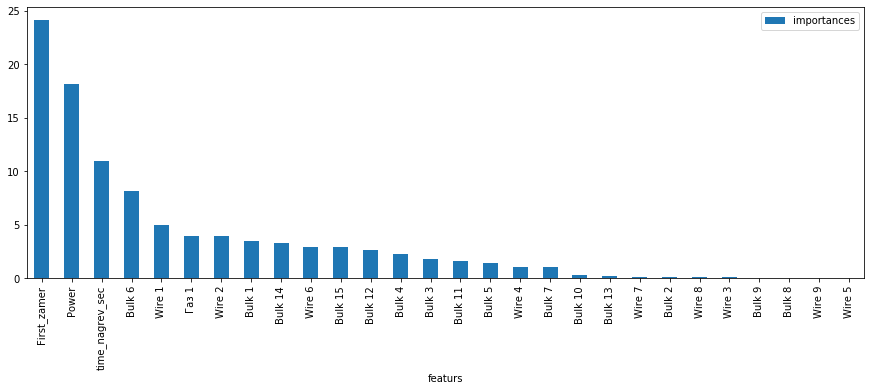

                     Влияние признаков на модель


In [200]:
import matplotlib.pyplot as plt
importances = modelCatBoost.feature_importances_
importances=importances.tolist()
featurs=features_train.columns.tolist()

importanc=pd.DataFrame({'importances': importances, 'featurs': featurs})

importanc = importanc.sort_values('importances', ascending=False)

importanc.plot(kind = 'bar', x='featurs', y='importances', 
                figsize=(15,5), sharex=False)
plt.show()
print('                     Влияние признаков на модель')

### 5.Выводы:

### - Модель DecisionTreeRegressor
#### Модель DecisionTreeRegressor с параметром max_depth=20 имеет:
- MAE_train: 0.19486675981521365
- MAE_test: 8.88854855835988
#### Эта модель склонна к переобучению.

###  - Модель CatBoostRegressor
#### На модели обученной с помощью CatBoostRegressor (с параметрами iterations=300, learning_rate = 0.08, max_depth=4) на тестовой выборке поличили метрику:
#### MAE = 6.1 на тестовой выборке

С помощью машинного обучения можно предсказывать температуру стали. Для этого пришлось использовать все доступные признаки/параметры от заказчика за исключением времени подачи легированных добавок. Если бы были более корректно собранные данные (треть откинули из замеров температуры) и было бы больше признаков/параметров от заказчика, модель могла бы быть точнее, а также можно было исследовать и предсказывать не только температуру нагрева стали.

# Вопросы тимлиду

1) Для всех ли партий применяли нагрев сплава в ковше?

2) Всегда ли добавляли легирующие добавки или, как вариант, сплав случайным образом при первых замерах уже имел необходимый целевой химический состав?

3) Есть ли "первичные данные" по температуре (может по хим. анализу тоже есть данные и первичные и дальнейшие?) до ввода легирующих добавок?

4) Существуют ли данные о весе/объёме партий первоначальных сплавов (сразу после того, как они оказались в ковше) до легирования или каждая партия весит одинаково (примерно 100 тонн), и на выходе должна получиться низколегированная сталь и поэтому влияние добавок на температуру практически нет?

5) Будет ли уместно сделать ещё столбцы по округлённым значениям (до первого знака после запятой) по времени нагрева дуги (разница между началом нагрева и концом) с помощью One-Hot Encoding?

6) Есть ли смысл в масштабировании данных?

7) Существует противоречие между тем, как описан один полный цикл для одной партии (измерение - нагрев и добавлением легирующих элементов - перемешивание - измерение) и наличием данных по измерениям температуры. Исходя из описания цикла складывается впечатление, что первое измерение температуры для первой партии должно быть хронологически раньше первого нагрева, а в данных таблицы data_time представлен первый замер температуры только после третьего нагрева дуги. Без этих данных по температуре можно строить адекватную "модель, которая предскажет температуру стали"? Я может что-то не правильно понимаю?

# План v1.0

1) Сначало надо избавиться от всяких редкостей, аномалий, выбросов по партиям (key), по которым имеется недостаток информации (К примеру, исходя из разницы в количестве key в data_gas и data_arc можно сделать вывод, что не все партии нагревали в ковше, но инертным газом пользовались)

2) Оставить выборку из партий, количество итераций (циклов) нагрева по которым находится в диапазоне между 3 и 6 (этот диапазон представляет большинство признаков)

3) Посчитать общую мощность S = (P+Q)**1/2; посчитать время нагрева (разница между началом нагрева и концом); заменить все NaN на нули.

4) Наверно объеденить все таблицы по "key".

5) Наверно назначить температуру из data_temp целевым признаком. Обучить модель несколькими способами. Сравнить.

# Отчёт тимлиду

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Не выполнен п.2, потому что это ещё сильнее сократилобы количество данных, что могло бы привести к неадекватной модели.


- Какие трудности возникли и как вы их преодолели?

Аномалии, выбросы... Инструменты предобработки данных позволили их преодолеть.


- Какие ключевые шаги в решении задачи выделили?

Исследование, Предобработка, Расчёт дополнительных признаков, Подготовка данных к МО, Построение моделей МО, Сравнение по метрике


- Какая ваша итоговая модель и какое у неё качество?

CatBoostRegressor (с параметрами iterations=300, learning_rate = 0.08, max_depth=4).
Метрика MAE = 6.1